## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
import warnings; warnings.filterwarnings("ignore")

## Read Data

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
'''
- data_info.csv 확인하기
- target: 출발지점에서 도착지점까지 걸리는 평균속도(km/h)
'''
train.sample(5)

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
1952301,TRAIN_1952301,20220320,일,15,1,103,일반국도12호선,0,0,60.0,...,0,함덕입구,33.536816,126.658816,없음,정성빌리지,33.537085,126.665889,없음,30.0
1252064,TRAIN_1252064,20220506,금,1,1,103,일반국도16호선,0,0,50.0,...,0,양수장,33.361717,126.766958,없음,제2가시교,33.364336,126.769409,없음,67.0
2121580,TRAIN_2121580,20220103,월,6,1,106,지방도97호선,0,0,60.0,...,3,대원교,33.438329,126.732032,없음,대원교,33.437946,126.732509,없음,56.0
2556467,TRAIN_2556467,20211205,일,22,2,106,중산간서로,0,0,50.0,...,0,더럭초교차로,33.452396,126.344994,없음,쉬는팡교차로,33.451901,126.341998,없음,37.0
801217,TRAIN_0801217,20220724,일,22,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서울이용원,33.246912,126.568186,없음,19.0


## 변수별 특징 추출

- base_date

In [4]:
print('학습 기간:', train.base_date.min(), '~', train.base_date.max())
print('예측 기간:', test.base_date.min(), '~', test.base_date.max())

학습 기간: 20210901 ~ 20220731
예측 기간: 20220801 ~ 20220831


- lane_count

In [5]:
# 제주도는 3차선까지만 있을 수 있다.
train.lane_count.value_counts()

2    2352092
1    1558531
3     790594
Name: lane_count, dtype: int64

- road_rating

In [6]:
# 103, 106, 107은 각각 일반국도, 지방도, 시도*군도를 의미한다.
train.road_rating.value_counts()

103    2159511
107    1582214
106     959492
Name: road_rating, dtype: int64

- road_name

In [7]:
# road_name에 결측치가 -로 표현되어 있다.
train.query('road_name=="-"').shape

(569463, 23)

- maximum_speed_limit

In [8]:
# 속도 제한은 30(어린이보호구역), 50, 60, 70, 80만 있다.
train.maximum_speed_limit.value_counts()

60.0    1665573
50.0    1103682
70.0     995077
80.0     700334
30.0     229761
40.0       6790
Name: maximum_speed_limit, dtype: int64

- `Category variable`

In [9]:
# vehincle_restricted, height_restricted는 1가지 값만 가진다.
train[['vehicle_restricted','height_restricted']].apply(pd.Series.nunique)

vehicle_restricted    1
height_restricted     1
dtype: int64

In [10]:
# 위의 두 컬럼처럼 범주형 변수이며 특정 범주의 비율이 높은 컬럼을 찾는다.(multi(2), binary(1))
category = ['road_rating', 'road_name', 'road_type',  'connect_code','vehicle_restricted', 
            'weight_restricted','height_restricted', 'start_node_name', 'end_node_name',
            'multi_linked', 'start_turn_restricted', 'end_turn_restricted']
category_dense = train[category].apply(lambda x: x.value_counts(normalize=True).iloc[0])
category_dense.sort_values()

start_node_name          0.008970
end_node_name            0.008990
road_name                0.222515
road_rating              0.459351
road_type                0.794925
weight_restricted        0.857836
end_turn_restricted      0.901809
start_turn_restricted    0.901831
connect_code             0.997417
multi_linked             0.999524
vehicle_restricted       1.000000
height_restricted        1.000000
dtype: float64

In [11]:
# [DC] 특정 범주가 95% 이상이면 유의미한 Feature를 생성할 수 없다고 판단하고 제거한다.
print(f'삭제되는 열은 {category_dense[category_dense > 0.95].index.values} 입니다.')
train.drop(category_dense[category_dense > 0.95].index, axis=1, inplace=True)
test.drop(category_dense[category_dense > 0.95].index, axis=1, inplace=True)

삭제되는 열은 ['connect_code' 'vehicle_restricted' 'height_restricted' 'multi_linked'] 입니다.


## 변수간 상관관계 분석
- target과 maximum_speed_limit은 약한 양의 상관관계를 갖는다.
- weight_restricted과도 약한 양의 상관관계를 갖는다.

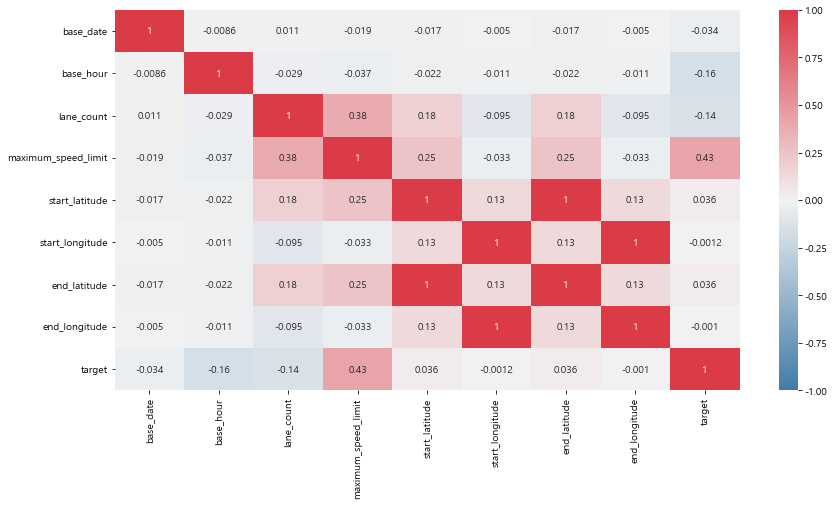

In [12]:
plt.figure(figsize = (14,7))
sns.heatmap(train[[i for i in train.columns if i not in category]].corr(), annot = True, 
            vmin=-1, vmax=1, cmap=sns.diverging_palette(240, 10, as_cmap=True))
plt.show()

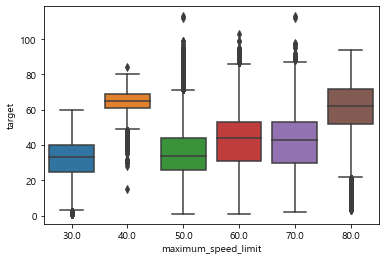

In [13]:
# 최대 제한 속도에 따라 평균 값의 차이가 다르다.
sns.boxplot(data = train, x = "maximum_speed_limit", y = "target")
plt.show()

In [14]:
# 새벽 때 속도가 빠르다.
for i in range(24):
    mean_time = train[train["base_hour"] == i]["target"].mean()
    print("{}시의 평균 속도는 {} km입니다". format(i, mean_time))

0시의 평균 속도는 48.74219956148886 km입니다
1시의 평균 속도는 49.76329975377427 km입니다
2시의 평균 속도는 50.27865841414583 km입니다
3시의 평균 속도는 50.54325437032667 km입니다
4시의 평균 속도는 49.747525471309984 km입니다
5시의 평균 속도는 47.20113952563933 km입니다
6시의 평균 속도는 45.549029131339154 km입니다
7시의 평균 속도는 43.682268249431075 km입니다
8시의 평균 속도는 41.65629226006192 km입니다
9시의 평균 속도는 40.87593935527232 km입니다
10시의 평균 속도는 40.22223191608988 km입니다
11시의 평균 속도는 39.82459295494329 km입니다
12시의 평균 속도는 39.83853790485902 km입니다
13시의 평균 속도는 39.73147080920405 km입니다
14시의 평균 속도는 39.561120915856606 km입니다
15시의 평균 속도는 39.35169967512037 km입니다
16시의 평균 속도는 39.127929181460516 km입니다
17시의 평균 속도는 38.47336318307683 km입니다
18시의 평균 속도는 38.2412578313253 km입니다
19시의 평균 속도는 40.10411206937628 km입니다
20시의 평균 속도는 41.11380627039048 km입니다
21시의 평균 속도는 42.17343124493455 km입니다
22시의 평균 속도는 43.989861884373646 km입니다
23시의 평균 속도는 45.807739281003535 km입니다


## Save Data

In [15]:
# 데이터 용량이 커 parquet로 저장한다.
train.to_parquet('../data/DC_train.pqt', engine='pyarrow', index=False)
test.to_parquet('../data/DC_test.pqt', engine='pyarrow', index=False)